## Expectation Maximization (EM)

In [32]:
import numpy as np
import time as T
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.utils.extmath import cartesian
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans

In [33]:
class MHP:
    def __init__(self, alpha=[[0.5]], mu=[0.1], omega=1.0):
        '''
        params should be of form
        alpha: numpy.array((u,u)), mu: numpy.array((,u)), omega: float
        '''
        
        self.data = []
        self.alpha, self.mu, self.omega = np.array(alpha), np.array(mu), omega
        self.dim = self.mu.shape[0]
        self.check_stability()

    def check_stability(self):
        '''
        check stability of process (max alpha eigenvalue < 1)
        '''
        w,v = np.linalg.eig(self.alpha)
        me = np.amax(np.abs(w))
        print('Max eigenvalue: %1.5f' % me)
        if me >= 1.:
            print('(WARNING) Unstable.')

### Generating simulated data

In [34]:
class MHP(MHP): # for Jupyter notebook
    
    def generate_seq(self, horizon):
        '''
        Generate a sequence based on mu, alpha, omega values. 
        Uses Ogata's thinning method, with some speedups, noted below
        '''

        self.data = []  # clear history

        Istar = np.sum(self.mu)
        s = np.random.exponential(scale=1./Istar)

        # attribute (weighted random sample, since sum(mu)==Istar)
        n0 = np.random.choice(np.arange(self.dim), 
                              1, 
                              p=(self.mu / Istar))
        self.data.append([s, n0])

        # value of \lambda(t_k) where k is most recent event
        # starts with just the base rate
        lastrates = self.mu.copy()

        decIstar = False
        while True:
            tj, uj = self.data[-1][0], int(self.data[-1][1])

            if decIstar:
                # if last event was rejected, decrease Istar
                Istar = np.sum(rates)
                decIstar = False
            else:
                # otherwise, we just had an event, so recalc Istar (inclusive of last event)
                Istar = np.sum(lastrates) + \
                        self.omega * np.sum(self.alpha[:,uj])

            # generate new event
            s += np.random.exponential(scale=1./Istar)

            # calc rates at time s (use trick to take advantage of rates at last event)
            rates = self.mu + np.exp(-self.omega * (s - tj)) * \
                    (self.alpha[:,uj].flatten() * self.omega + lastrates - self.mu)

            # attribution/rejection test
            # handle attribution and thinning in one step as weighted random sample
            diff = Istar - np.sum(rates)
            try:
                n0 = np.random.choice(np.arange(self.dim+1), 1, 
                                      p=(np.append(rates, diff) / Istar))
            except ValueError:
                # by construction this should not happen
                print('Probabilities do not sum to one.')
                self.data = np.array(self.data)
                return self.data

            if n0 < self.dim:
                self.data.append([s, n0])
                # update lastrates
                lastrates = rates.copy()
            else:
                decIstar = True

            # if past horizon, done
            if s >= horizon:
                self.data = np.array(self.data)
                self.data = self.data[self.data[:,0] < horizon]
                return self.data

### EM learning

In [35]:
class MHP(MHP): # for Jupyter notebook
    
    def EM(self, Ahat, mhat, omega, seq=[], smx=None, tmx=None, regularize=False, 
           Tm=-1, maxiter=100, epsilon=0.01, verbose=True):
        '''
        Implements MAP EM. Optional to regularize with `smx` and `tmx` matrix (shape=(dim,dim)).
        In general, the `tmx` matrix is a pseudocount of parent events from column j,
        and the `smx` matrix is a pseudocount of child events from column j -> i
        '''
        
        # if no sequence passed, uses class instance data
        if len(seq) == 0:
            seq = self.data

        N = len(seq)
        dim = mhat.shape[0]
        Tm = float(seq[-1,0]) if Tm < 0 else float(Tm)
        sequ = seq[:,1].astype(int)

        p_ii = np.random.uniform(0.01, 0.99, size=N)
        p_ij = np.random.uniform(0.01, 0.99, size=(N, N))

        # PRECOMPUTATIONS

        # diffs[i,j] = t_i - t_j for j < i (o.w. zero)
        diffs = pairwise_distances(np.array([seq[:,0]]).T, metric = 'euclidean')
        diffs[np.triu_indices(N)] = 0

        # kern[i,j] = omega*np.exp(-omega*diffs[i,j])
        kern = omega*np.exp(-omega*diffs)

        colidx = np.tile(sequ.reshape((1,N)), (N,1))
        rowidx = np.tile(sequ.reshape((N,1)), (1,N))

        # approx of Gt sum in a_{uu'} denom
        seqcnts = np.array([len(np.where(sequ==i)[0]) for i in range(dim)])
        seqcnts = np.tile(seqcnts, (dim,1))

        # returns sum of all pmat vals where u_i=a, u_j=b
        # *IF* pmat upper tri set to zero, this is 
        # \sum_{u_i=u}\sum_{u_j=u', j<i} p_{ij}
        def sum_pij(a,b):
            c = cartesian([np.where(seq[:,1]==int(a))[0], np.where(seq[:,1]==int(b))[0]])
            return np.sum(p_ij[c[:,0], c[:,1]])
        vp = np.vectorize(sum_pij)

        # \int_0^t g(t') dt' with g(t)=we^{-wt}
        # def G(t): return 1 - np.exp(-omega * t)
        #   vg = np.vectorize(G)
        # Gdenom = np.array([np.sum(vg(diffs[-1,np.where(seq[:,1]==i)])) for i in range(dim)])

        k = 0
        old_LL = -10000
        START = T.time()
        while k < maxiter:
            Auu = Ahat[rowidx, colidx]
            ag = np.multiply(Auu, kern)
            #print("before:", ag)
            #print(len(np.triu_indices(N)))
            ag[np.triu_indices(N)] = 0
            #print("--------------------")
            #print("after:", ag)
            #print(ag.shape)
            #assert 1==2

            # compute m_{u_i}
            mu = mhat[sequ]

            # compute total rates of u_i at time i
            rates = mu + np.sum(ag, axis=1)

            # compute matrix of p_ii and p_ij  (keep separate for later computations)
            p_ij = np.divide(ag, np.tile(np.array([rates]).T, (1,N)))
            p_ii = np.divide(mu, rates)

            # compute mhat:  mhat_u = (\sum_{u_i=u} p_ii) / T
            mhat = np.array([np.sum(p_ii[np.where(seq[:,1]==i)]) \
                             for i in range(dim)]) / Tm

            # ahat_{u,u'} = (\sum_{u_i=u}\sum_{u_j=u', j<i} p_ij) / \sum_{u_j=u'} G(T-t_j)
            # approximate with G(T-T_j) = 1
            if regularize:
                Ahat = np.divide(np.fromfunction(lambda i,j: vp(i,j), (dim,dim)) + (smx-1),
                                 seqcnts + tmx)
            else:
                Ahat = np.divide(np.fromfunction(lambda i,j: vp(i,j), (dim,dim)),
                                 seqcnts)

            if k % 10 == 0:
                try:
                    term1 = np.sum(np.log(rates))
                except:
                    print('Log error!')
                term2 = Tm * np.sum(mhat)
                term3 = np.sum(np.sum(Ahat[u,int(seq[j,1])] for j in range(N)) for u in range(dim))
                #new_LL = (1./N) * (term1 - term2 - term3)
                new_LL = (1./N) * (term1 - term3)
                if abs(new_LL - old_LL) <= epsilon:
                    if verbose:
                        print('Reached stopping criterion. (Old: %1.3f New: %1.3f)' % (old_LL, new_LL))
                    return Ahat, mhat
                if verbose:
                    print('After ITER %d (old: %1.3f new: %1.3f)' % (k, old_LL, new_LL))
                    print(' terms %1.4f, %1.4f, %1.4f' % (term1, term2, term3))

                old_LL = new_LL

            k += 1

        if verbose:
            print('Reached max iter (%d).' % maxiter)

        self.Ahat = Ahat
        self.mhat = mhat
        return Ahat, mhat

### Visualization

In [36]:
class MHP(MHP): # for Jupyter notebook
    
    def get_rate(self, ct, d):
        # return rate at time ct in dimension d
        seq = np.array(self.data)
        if not np.all(ct > seq[:,0]): seq = seq[seq[:,0] < ct]
        return self.mu[d] + \
            np.sum([self.alpha[d,int(j)]*self.omega*np.exp(-self.omega*(ct-t)) for t,j in seq])

In [37]:
class MHP(MHP): # for Jupyter notebook
    
    def plot_rates(self, horizon=-1):

        if horizon < 0:
            horizon = np.amax(self.data[:,0])

        f, axarr = plt.subplots(self.dim*2,1, sharex='col', 
                                gridspec_kw = {'height_ratios':sum([[3,1] for i in range(self.dim)],[])}, 
                                figsize=(8,self.dim*2))
        xs = np.linspace(0, horizon, (horizon/100.)*1000)
        for i in range(self.dim):
            row = i * 2

            # plot rate
            r = [self.get_rate(ct, i) for ct in xs]
            axarr[row].plot(xs, r, 'k-')
            axarr[row].set_ylim([-0.01, np.amax(r)+(np.amax(r)/2.)])
            axarr[row].set_ylabel('$\lambda(t)_{%d}$' % i, fontsize=14)
            r = []

            # plot events
            subseq = self.data[self.data[:,1]==i][:,0]
            axarr[row+1].plot(subseq, np.zeros(len(subseq)) - 0.5, 'bo', alpha=0.2)
            axarr[row+1].yaxis.set_visible(False)

            axarr[row+1].set_xlim([0, horizon])

        plt.tight_layout()

In [38]:
class MHP(MHP): # for Jupyter notebook
    
    def plot_events(self, horizon=-1, showDays=True, labeled=True):
        if horizon < 0:
            horizon = np.amax(self.data[:,0])

        fig = plt.figure(figsize=(10,2))
        ax = plt.gca()
        for i in range(self.dim):
            subseq = self.data[self.data[:,1]==i][:,0]
            plt.plot(subseq, np.zeros(len(subseq)) - i, 'bo', alpha=0.2)

        if showDays:
            for j in range(1,int(horizon)):
                plt.plot([j,j], [-self.dim, 1], 'k:', alpha=0.15)

        if labeled:
            ax.set_yticklabels('')
            ax.set_yticks(-np.arange(0, self.dim), minor=True)
            ax.set_yticklabels([r'$e_{%d}$' % i for i in range(self.dim)], minor=True)
        else:
            ax.yaxis.set_visible(False)

        ax.set_xlim([0,horizon])
        ax.set_ylim([-self.dim, 1])
        ax.set_xlabel('Days')
        plt.tight_layout()

### Experimentation

In [39]:
P = MHP()
seq = P.generate_seq(60)

print(seq)
print(type(seq))
print(seq.shape)

print(type(seq[0][1]))

Max eigenvalue: 0.50000
[[11.72757946  0.        ]
 [14.71966638  0.        ]
 [27.24703644  0.        ]
 [29.53440056  0.        ]
 [29.7873352   0.        ]
 [30.03778974  0.        ]
 [30.15454506  0.        ]
 [31.26318913  0.        ]
 [32.20861829  0.        ]
 [32.98644204  0.        ]
 [33.56164657  0.        ]
 [33.56941049  0.        ]
 [34.22067867  0.        ]
 [34.25264137  0.        ]
 [34.48359523  0.        ]
 [34.74467901  0.        ]
 [34.87963747  0.        ]
 [35.17936298  0.        ]
 [35.19431471  0.        ]
 [35.53596917  0.        ]
 [35.6316994   0.        ]
 [42.06755678  0.        ]
 [54.47435023  0.        ]
 [57.57836803  0.        ]
 [59.12145454  0.        ]
 [59.87980823  0.        ]]
<class 'numpy.ndarray'>
(26, 2)
<class 'numpy.float64'>


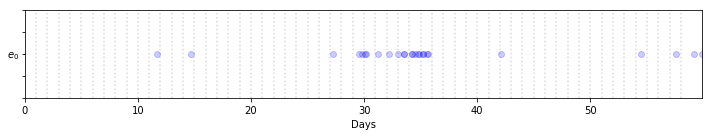

In [40]:
P.plot_events()

Max eigenvalue: 0.10000


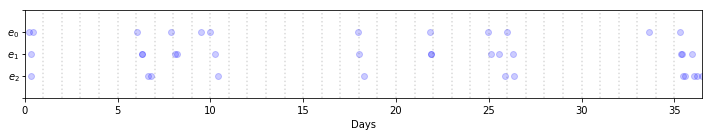

In [41]:
m = np.array([0.2, 0.0, 0.0])
a = np.array([[0.1, 0.0, 0.0], 
              [0.9, 0.0, 0.0],
              [0.0, 0.9, 0.0]])
w = 3.1

P = MHP(mu=m, alpha=a, omega=w)
P.generate_seq(60)
P.plot_events()

/opt/miniconda3/envs/sugar/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


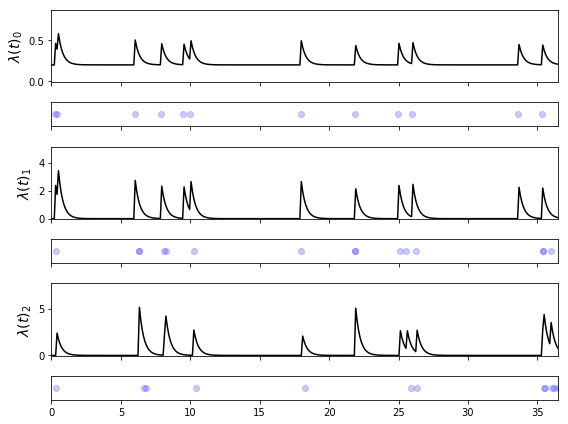

In [42]:
P.plot_rates()

In [43]:
mhat = np.random.uniform(0,1, size=3)
ahat = np.random.uniform(0,1, size=(3,3))
w = 3.

print(ahat)
print(mhat)

P.EM(ahat, mhat, w)

[[0.5733874  0.64663513 0.96815801]
 [0.0421581  0.87894648 0.69353244]
 [0.82799468 0.95048083 0.39436087]]
[0.4218636  0.46875807 0.56279336]
After ITER 0 (old: -10000.000 new: -0.193)
 terms 12.2106, 19.2806, 19.7194
After ITER 10 (old: -0.193 new: -0.638)
 terms 2.6413, 11.4712, 27.5288
Reached stopping criterion. (Old: -0.638 New: -0.637)


(array([[6.56775131e-07, 4.81954356e-07, 4.25384184e-02],
        [1.24998763e+00, 9.89411058e-06, 6.84091303e-12],
        [2.11695326e-08, 7.99903544e-01, 1.20548303e-04]]),
 array([3.14829994e-01, 1.64562144e-12, 6.41616271e-15]))

### Running on real data

In [44]:
events_d_one = pd.read_csv('event_times_ond_d_1314_ds0_one.csv')
events_d_all = pd.read_csv('event_times_ond_d_1314_ds0_all.csv')
events_hr_one = pd.read_csv('event_times_ond_hr_1314_ds0_one.csv')
events_hr_all = pd.read_csv('event_times_ond_hr_1314_ds0_all.csv')

print(events_d_one['unit'].nunique(), "total units")

events_d_one.head()

41 total units


,time,unit
0,224.0,E08
1,8.0,E04
2,349.0,E09
3,100.0,B07
4,169.0,P20


In [45]:
# MULTIVARIATE results for all dataframes

df_list = [events_d_one, events_d_all, events_hr_one, events_hr_all]

def run_multivariate_EM(df):
    num_units = df['unit'].nunique()
    df_augmented = df
    df_augmented['unit_num'] = pd.Categorical(df.unit).codes
    data = df_augmented[['time','unit_num']].values
    # Running EM
    A_init = np.random.uniform(0, 1, size=(num_units, num_units))
    mu_init = np.random.uniform(0, 1, size=num_units)
    w = 1.
    P = MHP(alpha=A_init, mu=mu_init, omega=w)
    A_learned, mu_learned = P.EM(A_init, mu_init, w, data)
    return A_learned, mu_learned

A_learned_list, mu_learned_list = [], []
for df in df_list:
    A_learned, mu_learned = run_multivariate_EM(df)
    A_learned_list.append(A_learned)
    mu_learned_list.append(mu_learned)
    print('----------------------------')

print('All A matrices:', A_learned_list) # count: 4
print('All mu vectors:', mu_learned_list) # count: 4

Max eigenvalue: 20.31538
(WARNING) Unstable.
After ITER 0 (old: -10000.000 new: -0.244)
 terms 316.2521, 494.6107, 577.3893
After ITER 10 (old: -0.244 new: -3.033)
 terms -2663.6722, 484.3922, 587.6078
Reached stopping criterion. (Old: -3.033 New: -3.033)
----------------------------
Max eigenvalue: 19.76354
(WARNING) Unstable.
After ITER 0 (old: -10000.000 new: -0.402)
 terms 382.5441, 402.4777, 910.5223
After ITER 10 (old: -0.402 new: -2.733)
 terms -2806.8003, 531.1535, 781.8465
Reached stopping criterion. (Old: -2.733 New: -2.726)
----------------------------
Max eigenvalue: 20.15018
(WARNING) Unstable.
After ITER 0 (old: -10000.000 new: -0.774)
 terms -771.6609, 1014.1662, 57.8338
After ITER 10 (old: -0.774 new: -5.892)
 terms -6163.3854, 919.3589, 152.6411
Reached stopping criterion. (Old: -5.892 New: -5.893)
----------------------------
Max eigenvalue: 20.59870
(WARNING) Unstable.
After ITER 0 (old: -10000.000 new: -0.804)
 terms -842.6997, 1100.3344, 212.6656
After ITER 10 (old

In [46]:
# UNIVARIATE results for all dataframes

def run_univariate_EM(df):
    alpha_init = np.random.uniform(0, 1, size=(1, 1))
    mu_init = np.random.uniform(0, 1, size=1)
    w = 1.
    
    num_units = df['unit'].nunique()
    df_augmented = df
    df_augmented['unit_num'] = pd.Categorical(df.unit).codes
    
    alpha_learned_list, mu_learned_list = [], []
    for i in range(num_units):
        df_i = df_augmented[df_augmented['unit_num'] == i]
        df_i['unit_num'] = 0
        data_i = df_i[['time','unit_num']].values
        #print(data_i)
    
        # Running EM
        P = MHP(alpha=alpha_init, mu=mu_init, omega=w)
        alpha_learned_i, mu_learned_i = P.EM(alpha_init, mu_init, w, data_i)
        alpha_learned_list.append(alpha_learned_i)
        mu_learned_list.append(mu_learned_i)
        
        flattened_alpha_learned_list = [item[0][0] for item in alpha_learned_list]
        flattened_mu_learned_list = [item[0] for item in mu_learned_list]
    
    return flattened_alpha_learned_list, flattened_mu_learned_list

In [47]:
# Trial on single dataframe

alpha_learned_list, mu_learned_list = run_univariate_EM(events_d_one)
print(alpha_learned_list)
print("-------------------")
print(mu_learned_list)

/opt/miniconda3/envs/sugar/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Max eigenvalue: 0.99363
After ITER 0 (old: -10000.000 new: -0.398)
 terms -10.6792, 28.1335, 0.8665
After ITER 10 (old: -0.398 new: -2.764)
 terms -80.1544, 28.9997, 0.0003
Reached stopping criterion. (Old: -2.764 New: -2.764)
Max eigenvalue: 0.99363
After ITER 0 (old: -10000.000 new: -0.381)
 terms -15.8403, 48.0409, 3.9591
After ITER 10 (old: -0.381 new: -2.227)
 terms -115.5167, 51.7226, 0.2774
Reached stopping criterion. (Old: -2.227 New: -2.222)
Max eigenvalue: 0.99363
After ITER 0 (old: -10000.000 new: -0.326)
 terms -0.7018, 3.3992, 0.6008
After ITER 10 (old: -0.326 new: -4.104)
 terms -15.4030, 2.9858, 1.0142
Reached stopping criterion. (Old: -4.104 New: -4.104)
Max eigenvalue: 0.99363
After ITER 0 (old: -10000.000 new: -0.404)
 terms -1.2121, 3.0000, 0.0000
After ITER 10 (old: -0.404 new: -4.944)
 terms -14.8321, 3.0000, 0.0000
Reached stopping criterion. (Old: -4.944 New: -4.944)
Max eigenvalue: 0.99363
After ITER 0 (old: -10000.000 new: -0.372)
 terms -10.4426, 33.0432, 2.95

Reached stopping criterion. (Old: -1.551 New: -1.551)
Max eigenvalue: 0.99363
After ITER 0 (old: -10000.000 new: -0.390)
 terms -14.7952, 42.2427, 2.7573
After ITER 10 (old: -0.390 new: -2.490)
 terms -111.9359, 44.9006, 0.0994
Reached stopping criterion. (Old: -2.490 New: -2.487)
[5.373017436383899e-09, 0.0009811052924064009, 0.2535408794030833, 0.0, 0.07127871273860492, 3.3481783513334584e-91, 0.039217039520240776, 3.3704550609152425e-22, 0.0015492869365822375, 0.1180667772113578, 1.8172322912715343e-69, 7.246490537957536e-55, 1.3458851742485913e-111, 7.089275650790432e-10, 1.6692724077911376e-07, 0.0128378194484276, 2.2205403920503097e-06, 3.788186241163357e-20, 0.006183833839522922, 2.7507988262628468e-12, 6.816331914389926e-18, 0.16176452821322124, 0.00013990884278742983, 0.04666318168541854, 1.0706351680408808e-07, 1.7923682731219093e-70, 0.007335617480035513, 0.03411294870158366, 8.897596837042765e-14, 3.7296882907547693e-63, 0.0007950560478441702, 5.046661130196705e-06, 0.00242

In [48]:
# Results for all dataframes

alpha_learned_list_uni, mu_learned_list_uni = [], []
for df in df_list:
    alpha_learned, mu_learned = run_univariate_EM(df)
    alpha_learned_list_uni.append(alpha_learned)
    mu_learned_list_uni.append(mu_learned)
    print('----------------------------')
    
print('All alpha values:', alpha_learned_list_uni) # count: 41x4
print('All mu values:', mu_learned_list_uni) # count: 41x4

Max eigenvalue: 0.10078
After ITER 0 (old: -10000.000 new: -0.247)
 terms -7.0668, 28.8947, 0.1053
After ITER 10 (old: -0.247 new: -2.764)
 terms -80.1540, 29.0000, 0.0000
Reached stopping criterion. (Old: -2.764 New: -2.764)
Max eigenvalue: 0.10078


/opt/miniconda3/envs/sugar/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


After ITER 0 (old: -10000.000 new: -0.247)
 terms -12.2655, 51.4248, 0.5752
After ITER 10 (old: -0.247 new: -2.223)
 terms -115.4801, 51.9071, 0.0929
Reached stopping criterion. (Old: -2.223 New: -2.221)
Max eigenvalue: 0.10078
After ITER 0 (old: -10000.000 new: -0.246)
 terms -0.8679, 3.8854, 0.1146
After ITER 10 (old: -0.246 new: -4.104)
 terms -15.4030, 2.9858, 1.0142
Reached stopping criterion. (Old: -4.104 New: -4.104)
Max eigenvalue: 0.10078
After ITER 0 (old: -10000.000 new: -0.247)
 terms -0.7422, 3.0000, 0.0000
After ITER 10 (old: -0.247 new: -4.944)
 terms -14.8321, 3.0000, 0.0000
Reached stopping criterion. (Old: -4.944 New: -4.944)
Max eigenvalue: 0.10078
After ITER 0 (old: -10000.000 new: -0.247)
 terms -8.4002, 35.5192, 0.4808
After ITER 10 (old: -0.247 new: -2.759)
 terms -96.8212, 33.5135, 2.4865
Reached stopping criterion. (Old: -2.759 New: -2.761)
Max eigenvalue: 0.10078
After ITER 0 (old: -10000.000 new: -0.247)
 terms -0.4948, 2.0000, 0.0000
After ITER 10 (old: -0.2

Max eigenvalue: 0.10078
After ITER 0 (old: -10000.000 new: -0.247)
 terms -10.0757, 41.6918, 0.3082
After ITER 10 (old: -0.247 new: -1.551)
 terms -65.1251, 42.0000, 0.0000
Reached stopping criterion. (Old: -1.551 New: -1.551)
Max eigenvalue: 0.10078
After ITER 0 (old: -10000.000 new: -0.247)
 terms -10.7727, 44.6487, 0.3513
After ITER 10 (old: -0.247 new: -2.487)
 terms -111.9107, 44.9789, 0.0211
Reached stopping criterion. (Old: -2.487 New: -2.487)
----------------------------
Max eigenvalue: 0.84633
After ITER 0 (old: -10000.000 new: -3.344)
 terms -96.1909, 25.8817, 4.1183
After ITER 10 (old: -3.344 new: -2.730)
 terms -81.9031, 29.9977, 0.0023
Reached stopping criterion. (Old: -2.730 New: -2.730)
Max eigenvalue: 0.84633
After ITER 0 (old: -10000.000 new: -3.092)
 terms -159.7763, 40.5298, 16.4702
After ITER 10 (old: -3.092 new: -2.157)
 terms -121.3242, 55.4005, 1.5995
Reached stopping criterion. (Old: -2.157 New: -2.147)
Max eigenvalue: 0.84633
After ITER 0 (old: -10000.000 new: 

Max eigenvalue: 0.84633
After ITER 0 (old: -10000.000 new: -3.365)
 terms -65.6736, 18.3727, 1.6273
After ITER 10 (old: -3.365 new: -3.223)
 terms -64.1856, 19.7344, 0.2656
Reached stopping criterion. (Old: -3.223 New: -3.222)
Max eigenvalue: 0.84633
After ITER 0 (old: -10000.000 new: -3.158)
 terms -93.7510, 24.6920, 7.3080
After ITER 10 (old: -3.158 new: -2.864)
 terms -89.1452, 29.4995, 2.5005
Reached stopping criterion. (Old: -2.864 New: -2.863)
Max eigenvalue: 0.84633
After ITER 0 (old: -10000.000 new: -3.223)
 terms -66.1349, 17.2399, 4.7601
After ITER 10 (old: -3.223 new: -3.195)
 terms -68.7555, 20.4644, 1.5356
Reached stopping criterion. (Old: -3.195 New: -3.193)
Max eigenvalue: 0.84633
After ITER 0 (old: -10000.000 new: -3.399)
 terms -56.1990, 15.4114, 1.5886
After ITER 10 (old: -3.399 new: -3.447)
 terms -58.6031, 16.9990, 0.0010
Reached stopping criterion. (Old: -3.447 New: -3.447)
Max eigenvalue: 0.84633
After ITER 0 (old: -10000.000 new: -3.121)
 terms -144.9675, 36.7974

Max eigenvalue: 0.41655
After ITER 0 (old: -10000.000 new: -0.303)
 terms -14.3515, 47.8008, 0.1992
After ITER 10 (old: -0.303 new: -5.587)
 terms -267.3599, 47.1918, 0.8082
Reached stopping criterion. (Old: -5.587 New: -5.587)
Max eigenvalue: 0.41655
After ITER 0 (old: -10000.000 new: -0.303)
 terms -20.0307, 66.0000, 0.0000
After ITER 10 (old: -0.303 new: -5.172)
 terms -341.3201, 66.0000, 0.0000
Reached stopping criterion. (Old: -5.172 New: -5.172)
Max eigenvalue: 0.41655
After ITER 0 (old: -10000.000 new: -0.303)
 terms -25.2307, 83.7564, 0.2436
After ITER 10 (old: -0.303 new: -5.026)
 terms -422.1039, 83.9478, 0.0522
Reached stopping criterion. (Old: -5.026 New: -5.025)
Max eigenvalue: 0.41655
After ITER 0 (old: -10000.000 new: -0.303)
 terms -6.0699, 20.0000, 0.0000
After ITER 10 (old: -0.303 new: -6.390)
 terms -127.8015, 20.0000, 0.0000
Reached stopping criterion. (Old: -6.390 New: -6.390)
Max eigenvalue: 0.41655
After ITER 0 (old: -10000.000 new: -0.303)
 terms -9.4046, 30.996

Max eigenvalue: 0.10658
After ITER 0 (old: -10000.000 new: -0.782)
 terms -3.1288, 4.0000, 0.0000
After ITER 10 (old: -0.782 new: -6.363)
 terms -25.4504, 4.0000, 0.0000
Reached stopping criterion. (Old: -6.363 New: -6.363)
Max eigenvalue: 0.10658
After ITER 0 (old: -10000.000 new: -0.782)
 terms -18.7720, 23.9994, 0.0006
After ITER 10 (old: -0.782 new: -5.846)
 terms -140.3145, 24.0000, 0.0000
Reached stopping criterion. (Old: -5.846 New: -5.846)
Max eigenvalue: 0.10658
After ITER 0 (old: -10000.000 new: -0.782)
 terms -21.8954, 27.9942, 0.0058
After ITER 10 (old: -0.782 new: -6.017)
 terms -168.4670, 28.0000, 0.0000
Reached stopping criterion. (Old: -6.017 New: -6.017)
Max eigenvalue: 0.10658
After ITER 0 (old: -10000.000 new: -0.782)
 terms -13.2972, 17.0000, 0.0000
After ITER 10 (old: -0.782 new: -6.516)
 terms -110.7664, 17.0000, 0.0000
Reached stopping criterion. (Old: -6.516 New: -6.516)
Max eigenvalue: 0.10658
After ITER 0 (old: -10000.000 new: -0.782)
 terms -14.0794, 18.0000,

## Plots

### Multivariate

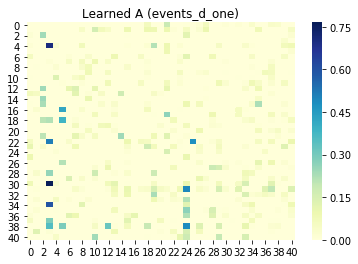

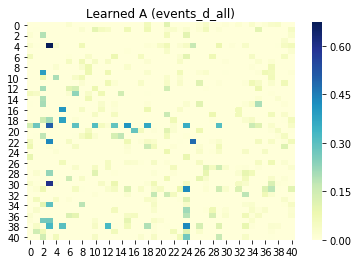

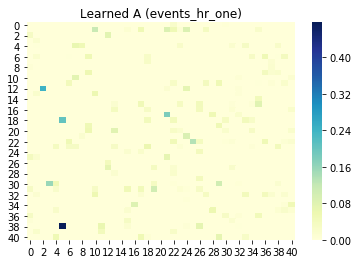

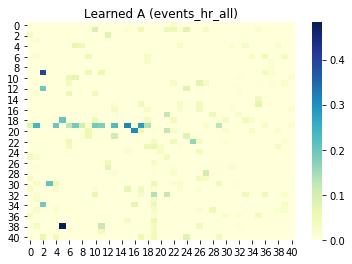

In [49]:
A_events_d_one = A_learned_list[0]
A_events_d_all = A_learned_list[1]
A_events_hr_one = A_learned_list[2]
A_events_hr_all = A_learned_list[3]

ax0 = sns.heatmap(A_events_d_one, cmap="YlGnBu")
ax0.set_title("Learned A (events_d_one)")
plt.show()

ax1 = sns.heatmap(A_events_d_all, cmap="YlGnBu")
ax1.set_title("Learned A (events_d_all)")
plt.show()

ax2 = sns.heatmap(A_events_hr_one, cmap="YlGnBu")
ax2.set_title("Learned A (events_hr_one)")
plt.show()

ax3 = sns.heatmap(A_events_hr_all, cmap="YlGnBu")
ax3.set_title("Learned A (events_hr_all)")
plt.show()

### Univariate

#### 1D scatter plots

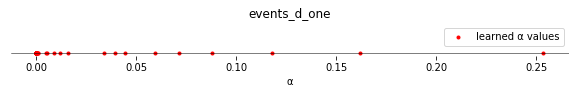

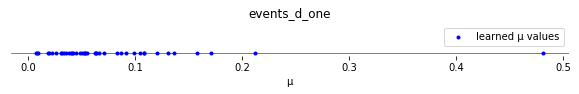

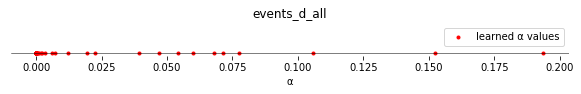

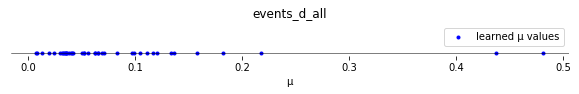

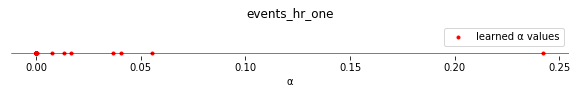

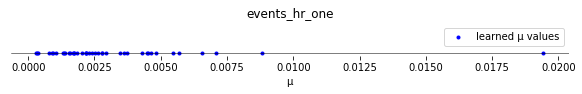

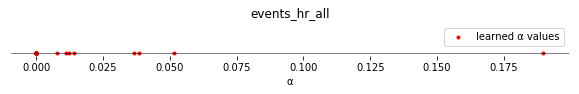

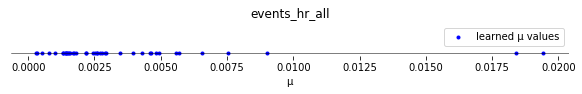

In [50]:
def generate_density_plots(df_name, alpha_i, mu_i):
    # alpha
    fig0 = plt.figure(facecolor='white')
    ax0 = plt.axes(frameon=False)
    ax0.get_xaxis().tick_bottom()   
    ax0.axes.get_yaxis().set_visible(False) 
    x = alpha_i
    y = [0.5]*len(x)
    ax0.plot(x, y, 'r.', markersize=6, label='learned α values')
    fig0.set_size_inches(10, 0.6)
    plt.xlabel("α")
    plt.legend(loc='best')
    xmin, xmax = ax0.get_xaxis().get_view_interval()
    ymin, ymax = ax0.get_yaxis().get_view_interval()
    ax0.axes.set_ylim([-1, 15])
    ax0.add_artist(Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=0.5))
    plt.title(df_name)
    plt.show()

    # mu
    fig0 = plt.figure(facecolor='white')
    ax0 = plt.axes(frameon=False)
    ax0.get_xaxis().tick_bottom()   
    ax0.axes.get_yaxis().set_visible(False) 
    x = mu_i
    y = [0.5]*len(x)
    ax0.plot(x, y, 'b.', markersize=6, label='learned μ values')
    fig0.set_size_inches(10, 0.6)
    plt.xlabel("μ")
    plt.legend(loc='best')
    xmin, xmax = ax0.get_xaxis().get_view_interval()
    ymin, ymax = ax0.get_yaxis().get_view_interval()
    ax0.axes.set_ylim([-1, 15])
    ax0.add_artist(Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=0.5))
    plt.title(df_name)
    plt.show()   
    
df_names_list = ['events_d_one', 'events_d_all', 'events_hr_one', 'events_hr_all']
for i in range(len(df_names_list)):
    generate_density_plots(df_names_list[i], alpha_learned_list_uni[i], mu_learned_list_uni[i])

#### Clustering of (α, μ) parameter values

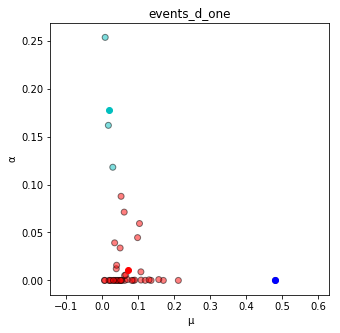

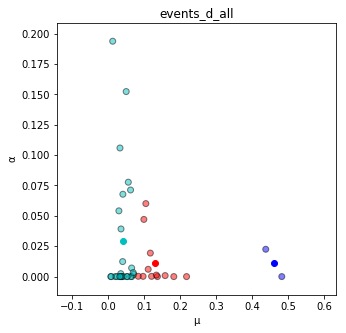

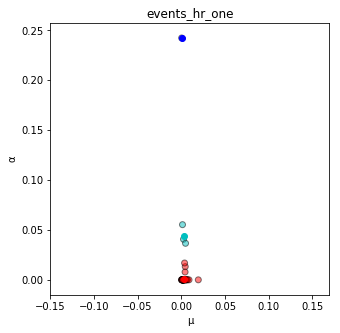

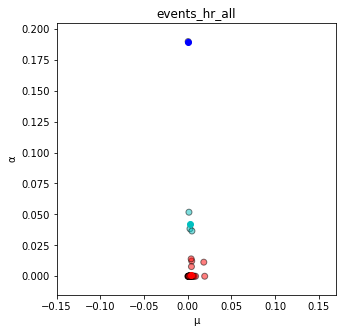

In [51]:
def generate_cluster_plots(df_name, x_list, y_list, n_clusters=3):
    df_kmeans = pd.DataFrame({'x': x_list, 'y': y_list})
    kmeans = KMeans(n_clusters)
    kmeans.fit(df_kmeans)

    labels = kmeans.predict(df_kmeans)
    centroids = kmeans.cluster_centers_
    
    fig = plt.figure(figsize=(5, 5))
    colmap = {1: 'r', 2: 'b', 3: 'c', 4: 'g', 5: 'm', 6: 'y'}
    colors = list(map(lambda x: colmap[x+1], labels))

    plt.scatter(df_kmeans['x'], df_kmeans['y'], color=colors, alpha=0.5, edgecolor='k')
    for idx, centroid in enumerate(centroids):
        plt.scatter(*centroid, color=colmap[idx+1])

    plt.xlim(min(x_list)-0.15, max(x_list)+0.15)
    plt.ylim(min(y_list)-0.015, max(y_list)+0.015)

    plt.xlabel("μ")
    plt.ylabel("α")
    plt.title(df_name)
    plt.show()
    
for i in range(len(df_names_list)):
    generate_cluster_plots(df_names_list[i], mu_learned_list_uni[i], alpha_learned_list_uni[i])

### Updated Plots
Only displaying units with 30 or more events

In [73]:
# ONE

df_list_small = [events_d_one, events_d_all] # only day events

#print(events_d_one) # Why does events_d_one have a 'unit_num' column? 
sorted_events_d_one = events_d_one.sort_values(by=['unit_num'])
#print(sorted_events_d_one)

#events_units_counts = pd.DataFrame(events_d_one['unit_num'].value_counts(), columns = ['unit_num', 'frequency'])
#events_units_counts = pd.DataFrame(events_d_one['unit_num'].value_counts()) #.to_dict()
#print(events_units_counts)
#print(events_units_counts.shape)

events_units_counts = events_d_one.join(events_d_one['unit_num'].value_counts().rename('frequency'), on='unit_num')
#print(events_units_counts)

threshold = 30
events_units_counts_selected = events_units_counts[events_units_counts['frequency'] >= threshold]
num_selected_units = events_units_counts_selected['unit'].nunique()
print('Number of units with lots of events:', num_selected_units)
print(events_units_counts_selected)

#df_augmented_small = events_d_one
#df_augmented_small['unit_num'] = pd.Categorical(df.unit).codes
#df_augmented_small.head()

Number of units with lots of events: 14
       time unit  unit_num  frequency
3     100.0  B07         1         52
4     169.0  P20        32         84
5     457.0  W11        40         45
6     308.0  P20        32         84
7     282.0  P20        32         84
8     377.0  E19        18         32
9     454.0  E16        15         49
10    352.0  W08        37         50
12     66.0  W10        39         42
13      9.0  G11        23         52
14    147.0  P20        32         84
15    407.0  G11        23         52
16     95.0  E16        15         49
17     46.0  W11        40         45
19    203.0  E19        18         32
21    177.0  W08        37         50
22    220.0  B07         1         52
27    326.0  W08        37         50
28    310.0  G09        22         34
29    459.0  E19        18         32
30    102.0  W09        38         45
31    487.0  E16        15         49
32     27.0  L09        30         48
34    303.0  W11        40         45
35    327.

In [74]:
# ALL

sorted_events_d_all = events_d_all.sort_values(by=['unit_num'])
events_units_counts_all = events_d_all.join(events_d_all['unit_num'].value_counts().rename('frequency'), on='unit_num')
threshold = 30
events_units_counts_selected_all = events_units_counts_all[events_units_counts_all['frequency'] >= threshold]
#num_selected_units = events_units_counts_selected['unit'].nunique()

In [75]:
# Mapping
print('Mapping (one)')
mapping_one = events_units_counts_selected.groupby(['unit', 'unit_num']).size().reset_index(name='frequency')[['unit', 'unit_num']]
print(mapping_one)

print('Mapping (all)')
mapping_all = events_units_counts_selected_all.groupby(['unit', 'unit_num']).size().reset_index(name='frequency')[['unit', 'unit_num']]
print(mapping_all)

Mapping (one)
   unit  unit_num
0   B07         1
1   B12         4
2   E16        15
3   E19        18
4   G09        22
5   G11        23
6   L09        30
7   L10        31
8   P20        32
9   P22        34
10  W08        37
11  W09        38
12  W10        39
13  W11        40
Mapping (all)
   unit  unit_num
0   B06         0
1   B07         1
2   B12         4
3   E16        15
4   E19        18
5   EMD        19
6   G09        22
7   G11        23
8   L09        30
9   L10        31
10  P20        32
11  P22        34
12  W08        37
13  W09        38
14  W10        39
15  W11        40


In [86]:
# Mapping, with frequency 
print('Mapping (one), with frequency')
mapping_one_freq = events_units_counts_selected.groupby(['unit', 'frequency']).size().reset_index(name='freq')[['unit', 'frequency']]
print(mapping_one)

print('Mapping (all), with frequency')
mapping_all_freq = events_units_counts_selected_all.groupby(['unit', 'frequency']).size().reset_index(name='freq')[['unit', 'frequency']]
print(mapping_all)

Mapping (one), with frequency
   unit  frequency
0   B07         52
1   B12         36
2   E16         49
3   E19         32
4   G09         34
5   G11         52
6   L09         48
7   L10         66
8   P20         84
9   P22         31
10  W08         50
11  W09         45
12  W10         42
13  W11         45
Mapping (all), with frequency
   unit  frequency
0   B06         30
1   B07         57
2   B12         36
3   E16         50
4   E19         33
5   EMD        228
6   G09         34
7   G11         52
8   L09         51
9   L10         66
10  P20         84
11  P22         32
12  W08         51
13  W09         45
14  W10         43
15  W11         45


#### Running multivariate EM

In [64]:
df_for_em_small = events_units_counts_selected[['time', 'unit']]
df_for_em_small2 = events_units_counts_selected_all[['time', 'unit']]

#print(df_for_em_small)
df_list_small_temp = [df_for_em_small, df_for_em_small2]

A_learned_list, mu_learned_list = [], []
for df in df_list_small_temp:
    A_learned, mu_learned = run_multivariate_EM(df)
    A_learned_list.append(A_learned)
    mu_learned_list.append(mu_learned)
    print('----------------------------')

print('All A matrices:', A_learned_list) 
print('All mu vectors:', mu_learned_list)

/opt/miniconda3/envs/sugar/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Max eigenvalue: 7.31860
(WARNING) Unstable.
After ITER 0 (old: -10000.000 new: -0.735)
 terms -124.0473, 300.2669, 365.7331
After ITER 10 (old: -0.735 new: -2.630)
 terms -1518.9721, 433.3993, 232.6007
After ITER 20 (old: -2.630 new: -2.611)
 terms -1516.4147, 443.4509, 222.5491
Reached stopping criterion. (Old: -2.611 New: -2.606)
----------------------------
Max eigenvalue: 7.92204
(WARNING) Unstable.
After ITER 0 (old: -10000.000 new: -0.193)
 terms 272.5865, 483.8243, 453.1757
After ITER 10 (old: -0.193 new: -2.303)
 terms -1761.3691, 540.3946, 396.6054
Reached stopping criterion. (Old: -2.303 New: -2.300)
----------------------------
All A matrices: [array([[9.11073310e-07, 4.37767264e-12, 9.45387603e-02, 9.23501016e-02,
        4.43977837e-03, 1.52040191e-03, 1.56808535e-09, 6.10848310e-12,
        1.58599087e-06, 9.55001588e-04, 2.62817742e-02, 4.95760375e-18,
        6.65004472e-05, 5.79356715e-02],
       [3.45054517e-03, 4.31077169e-02, 2.93135274e-05, 2.68782474e-02,
       

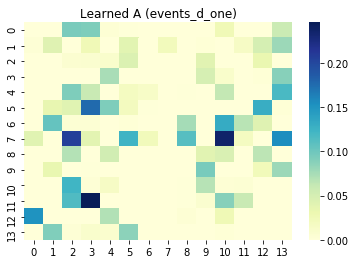

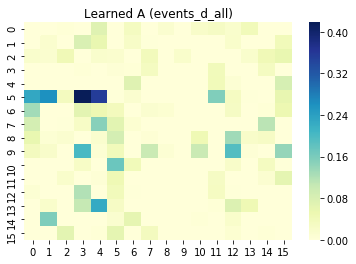

In [65]:
A_events_d_one = A_learned_list[0]
A_events_d_all = A_learned_list[1]

ax0 = sns.heatmap(A_events_d_one, cmap="YlGnBu")
ax0.set_title("Learned A (events_d_one)")
plt.show()

ax1 = sns.heatmap(A_events_d_all, cmap="YlGnBu")
ax1.set_title("Learned A (events_d_all)")
plt.show()

#### Running univariate EM

In [87]:
alpha_learned_list_uni, mu_learned_list_uni = [], []
for df in df_list_small_temp:
    alpha_learned, mu_learned = run_univariate_EM(df)
    alpha_learned_list_uni.append(alpha_learned)
    mu_learned_list_uni.append(mu_learned)
    print('----------------------------')
    
print('All alpha values:', alpha_learned_list_uni) # count: 41x4
print('All mu values:', mu_learned_list_uni)

/opt/miniconda3/envs/sugar/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Max eigenvalue: 0.52101
After ITER 0 (old: -10000.000 new: -0.409)
 terms -18.6826, 49.3921, 2.6079
After ITER 10 (old: -0.409 new: -2.226)
 terms -115.5076, 51.7656, 0.2344
Reached stopping criterion. (Old: -2.226 New: -2.221)
Max eigenvalue: 0.52101
After ITER 0 (old: -10000.000 new: -0.405)
 terms -12.5558, 33.9644, 2.0356
After ITER 10 (old: -0.405 new: -2.761)
 terms -96.8199, 33.4399, 2.5601
Reached stopping criterion. (Old: -2.761 New: -2.761)
Max eigenvalue: 0.52101
After ITER 0 (old: -10000.000 new: -0.407)
 terms -16.9930, 46.0425, 2.9575
After ITER 10 (old: -0.407 new: -2.234)
 terms -108.5595, 48.0861, 0.9139
Reached stopping criterion. (Old: -2.234 New: -2.227)
Max eigenvalue: 0.52101
After ITER 0 (old: -10000.000 new: -0.410)
 terms -12.1332, 31.0020, 0.9980
After ITER 10 (old: -0.410 new: -2.769)
 terms -88.3456, 31.7264, 0.2736
Reached stopping criterion. (Old: -2.769 New: -2.767)
Max eigenvalue: 0.52101
After ITER 0 (old: -10000.000 new: -0.408)
 terms -12.3491, 32.493

In [88]:
print(len(mu_learned_list_uni[0]))
print(len(mu_learned_list_uni[1]))

14
16


In [130]:
def generate_cluster_plots_labels(df_name, x_list, y_list, labels_list, n_clusters=3):
    df_kmeans = pd.DataFrame({'x': x_list, 'y': y_list})
    kmeans = KMeans(n_clusters)
    kmeans.fit(df_kmeans)
    labels = kmeans.predict(df_kmeans)
    centroids = kmeans.cluster_centers_
    
    fig = plt.figure(figsize=(20, 5))
    colmap = {1: 'r', 2: 'b', 3: 'c', 4: 'g', 5: 'm', 6: 'y'}
    colors = list(map(lambda x: colmap[x+1], labels))

    plt.scatter(df_kmeans['x'], df_kmeans['y'], color=colors, alpha=0.75, edgecolor='k', s=125)
    for idx, centroid in enumerate(centroids):
        plt.scatter(*centroid, color=colmap[idx+1], s=300, alpha=0.25)

    plt.xlim(min(x_list)-0.15, max(x_list)+0.15)
    plt.ylim(min(y_list)-0.015, max(y_list)+0.015)

    plt.xlabel("μ")
    plt.ylabel("α")
    plt.title(df_name)
    
    # Adding unit labels to points
    #fig, ax = plt.subplots()
    for i, txt in enumerate(labels_list):
        plt.annotate(txt, (x_list[i], y_list[i]))
    
    plt.show()

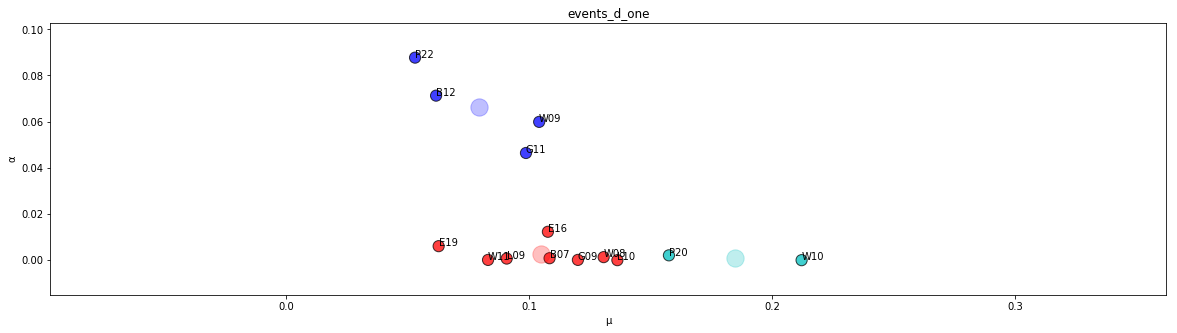

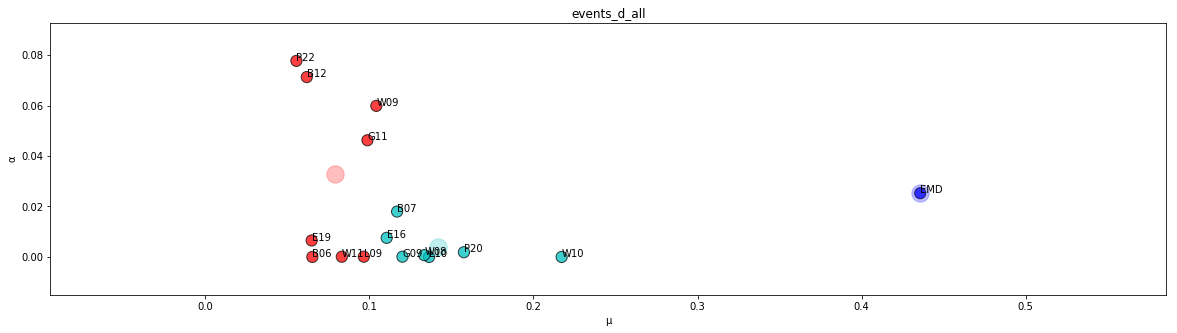

In [131]:
df_names_list_small = ['events_d_one', 'events_d_all'] # not used

labels_one = mapping_one_freq['unit']
labels_all = mapping_all_freq['unit']

generate_cluster_plots_labels('events_d_one', mu_learned_list_uni[0], alpha_learned_list_uni[0], labels_one)
generate_cluster_plots_labels('events_d_all', mu_learned_list_uni[1], alpha_learned_list_uni[1], labels_all)

#for i in range(len(df_names_list_small)):
#    generate_cluster_plots_labels(df_names_list_small[i], mu_learned_list_uni[i], alpha_learned_list_uni[i])

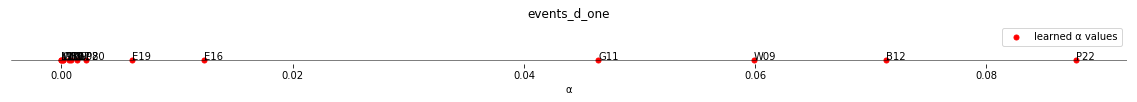

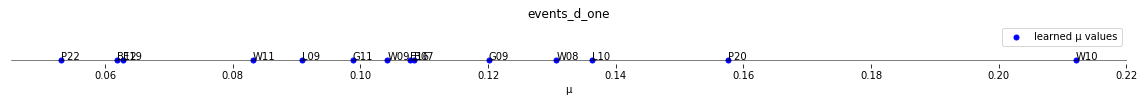

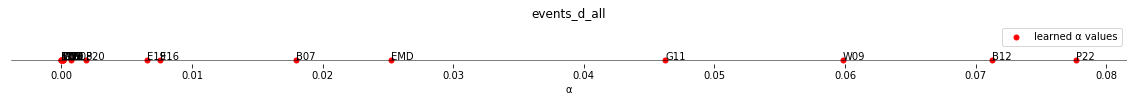

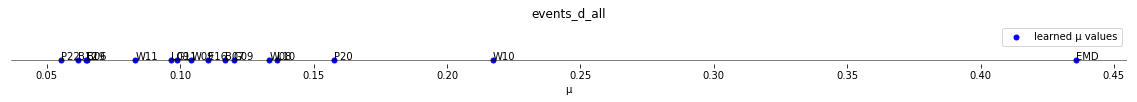

In [139]:
def generate_density_plots_labels(df_name, alpha_i, mu_i, labels_list):
    # alpha
    fig0 = plt.figure(facecolor='white')
    ax0 = plt.axes(frameon=False)
    ax0.get_xaxis().tick_bottom()   
    ax0.axes.get_yaxis().set_visible(False) 
    x = alpha_i
    y = [0.5]*len(x)
    ax0.plot(x, y, 'r.', markersize=10, label='learned α values')
    fig0.set_size_inches(20, 0.75)
    plt.xlabel("α")
    plt.legend(loc='best')
    xmin, xmax = ax0.get_xaxis().get_view_interval()
    ymin, ymax = ax0.get_yaxis().get_view_interval()
    ax0.axes.set_ylim([-1, 15])
    ax0.add_artist(Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=0.5))
    plt.title(df_name)
    
    # Adding unit labels to points
    for i, txt in enumerate(labels_list):
        plt.annotate(txt, (x[i], y[i]))
        
    plt.show()

    # mu
    fig0 = plt.figure(facecolor='white')
    ax0 = plt.axes(frameon=False)
    ax0.get_xaxis().tick_bottom()   
    ax0.axes.get_yaxis().set_visible(False) 
    x = mu_i
    y = [0.5]*len(x)
    ax0.plot(x, y, 'b.', markersize=10, label='learned μ values')
    fig0.set_size_inches(20, 0.75)
    plt.xlabel("μ")
    plt.legend(loc='best')
    xmin, xmax = ax0.get_xaxis().get_view_interval()
    ymin, ymax = ax0.get_yaxis().get_view_interval()
    ax0.axes.set_ylim([-1, 15])
    ax0.add_artist(Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=0.5))
    plt.title(df_name)
    
    # Adding unit labels to points
    for i, txt in enumerate(labels_list):
        plt.annotate(txt, (x[i], y[i]))
    
    plt.show()

generate_density_plots_labels('events_d_one', alpha_learned_list_uni[0], mu_learned_list_uni[0], labels_one)
generate_density_plots_labels('events_d_all', alpha_learned_list_uni[1], mu_learned_list_uni[1], labels_all)